# Example script for the TailCutsDataVolumeReducer

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ctapipe
from ctapipe.io import event_source
from ctapipe import utils
from ctapipe.calib import CameraCalibrator
from ctapipe.visualization import CameraDisplay
from ctapipe.image.reducer import TailCutsDataVolumeReducer
from ctapipe.instrument import CameraGeometry

### 1) Import data and camera_geom

In [2]:
data = utils.get_dataset_path("gamma_test_large.simtel.gz")
source = event_source(data, allowed_tels=[1,2,3,4],  max_events=2)
camera = CameraGeometry.from_name("LSTCam")

Sampling rate is not in file, defaulting to 1.0 GHz


### 2) Define reduction parameters

 - Camera_geom is needed <br>
 - Default values are: <br>
&emsp; picture_thresh = 10 <br>
&emsp; boundary_thresh = 5 <br>
&emsp; end_dilates = 1 <br>
&emsp; keep_isolated_pixels = True <br>
&emsp; min_number_picture_neighbors = 0

In [3]:
# VolumeReducer
volume_reducer = TailCutsDataVolumeReducer()
# reduction parameters
volume_reducer.camera_geom = camera
volume_reducer.picture_thresh = 10
volume_reducer.boundary_thresh = 5
volume_reducer.end_dilates = 1
volume_reducer.keep_isolated_pixels = True
volume_reducer.min_number_picture_neighbors = 0

### 3.1) First variant
Simple way with CameraCalibrator.
 - Use TailCutsDataVolumeReducer in CameraCalibrator
 - Get reduced image
 - Plot image

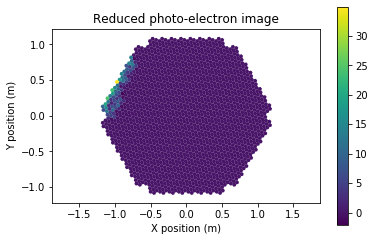

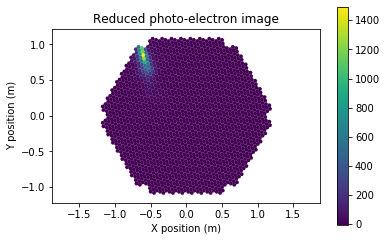

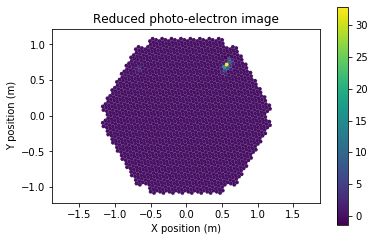

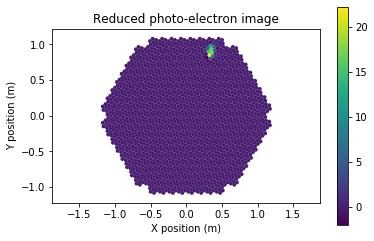

In [4]:
#loop over events
for event in source:
    subarray = event.inst.subarray
    calib = CameraCalibrator(data_volume_reducer=volume_reducer,
                             subarray=subarray)
    calib(event)
    # loop over telescopes
    for tel_id in event.dl0.tels_with_data:
        
        # get reduced image
        reduced_pe_image = event.dl1.tel[tel_id].image

        # plot reduced image
        disp = CameraDisplay(camera, image=reduced_pe_image)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("Reduced photo-electron image")
        disp.add_colorbar()
        cb1 = disp.colorbar
        plt.show()


### 3.2) Second variant
For comparative studies - Here you can make a comparison between the reduced and unreduced image.
 - Use NullDataVolumeReducer in CameraCalibrator
 - Get Waveforms (DL0) and unreduced image (DL1)
 - Use TailCutsDataVolumeReducer manually on waveforms (DL0) and get mask 
 - Use mask on unreduced image (DL1) and get reduced image
 - Plot reduced and unreduced image

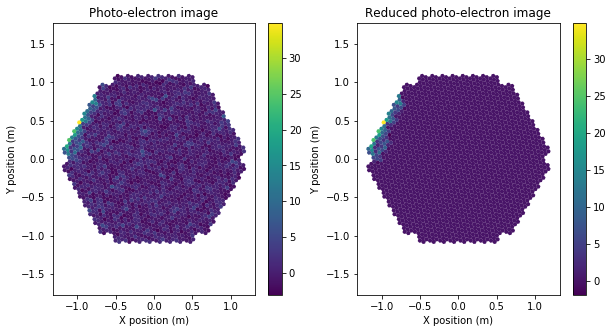

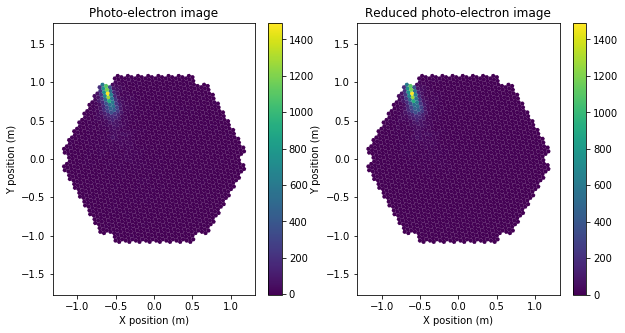

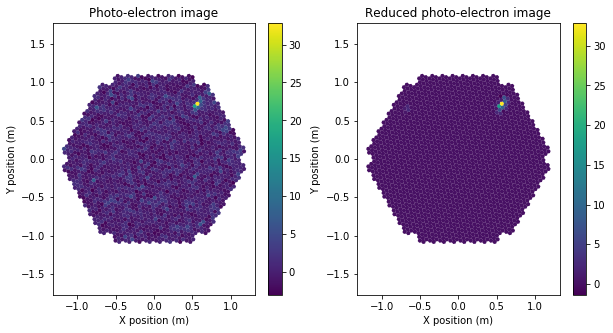

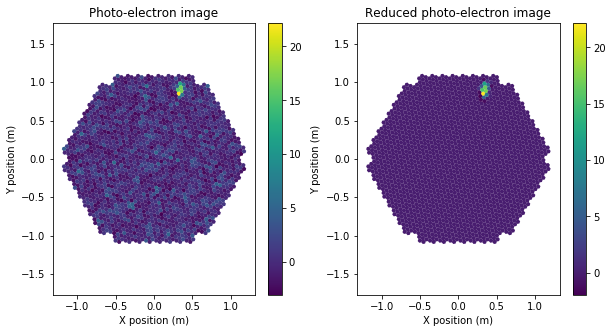

In [4]:
# loop over events
for event in source:
    subarray = event.inst.subarray
    calib = CameraCalibrator(subarray=subarray)
    calib(event)
    # loop over telescopes
    for tel_id in event.dl0.tels_with_data:
        
        # get camera images
        waveforms = event.dl0.tel[tel_id].waveform
        pe_image = event.dl1.tel[tel_id].image

        # reduction
        reduced_pe_image = pe_image.copy()
        mask = volume_reducer(waveforms)
        reduced_pe_image[~mask] = 0

        # plot reduced and unreduced image
        plt.figure(figsize=(10,5))
        ax1 = plt.subplot(121)
        disp1 = CameraDisplay(camera, image=pe_image)
        disp1.add_colorbar()
        ax1.set_title("Photo-electron image")
        ax2 = plt.subplot(122)
        disp2 = CameraDisplay(camera, image=reduced_pe_image)
        disp2.add_colorbar()
        ax2.set_title("Reduced photo-electron image")
        plt.show()
